Will and Shawn try coding

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# voltage across the solenoid (controller output)
# force on the magnet
# acceleration, velocity, position of magnet
# time
# target position
# measured position

times = np.linspace(0, 10, 100)
df = pd.DataFrame(index = times)

In [11]:
#definition of constants
g = 9.81 #gravity
m = .1   #mass 
cm = 1   #hall effect sensor mass coefficient
cv = 1   #hall effect sensor solenoid coefficient
cf = 1   #force of solenoid coefficient

#definition of simulation variables
size = 25   #number of points to plot
delta_t = .01 #time step between points
kp = 2       #proportional constant
kd = 1       #derivative constant
ki = 20       #integral constant
i_gain  = 0  #gain of integral part of controller
xi = .1      #starting position

#definition of input signal
target =  0.5

In [15]:
# define intial condiations
df = pd.DataFrame({
#     "target" :  [target], 
    "pos" : [target],
    "p_meas" : [target],
    "vel" : [0.0],
    "accel" : [0.0],
    "voltage" : [0.0],
    "force" : [m*g]
})

# def update_status(df):
#     last_pos = df.iloc[-1]
    


target     0.500
pos        0.500
p_meas     0.500
vel        0.000
accel      0.000
voltage    0.000
force      0.981
Name: 0, dtype: float64

In [16]:
df.iloc[-1].target

0.5

In [17]:
df1 = pd.DataFrame({
#     "target" :  [target], 
    "pos" : [target],
    "p_meas" : [target],
    "vel" : [1],
    "accel" : [1],
    "voltage" : [1],
    "force" : [m*g+1]
})

In [19]:
df.append(df1, sort=False)

,target,pos,p_meas,vel,accel,voltage,force
0,0.5,0.5,0.5,0.0,0.0,0.0,0.981
0,NaN,0.5,0.5,1.0,1.0,1.0,1.981


In [70]:
def get_force(force, voltage, pos, cf):
    '''
    Returns the net force applied to the permanent magnet

    force: force array
    voltage: voltage array
    pos: position array
    cf: force constant
    '''
    new = m*g - cf * voltage[-1] / (pos[-1]**2)
    return np.append(np.delete(force, 0), new)

def get_acceleration(accel, force, m):
    '''
    Returns the velocity of the permanent magnet

    accel: acceeration array
    force: force array
    m: mass
    '''
    new = force[-1]/m
    return np.append(np.delete(accel, 0), new)

def get_velocity(vel, accel):
    '''
    Returns the velocity of the permanent magnet

    vel: velocity array
    accel: acceleration array
    '''
    new = accel[-1]*delta_t + vel[-1]
    return np.append(np.delete(vel, 0), new)

def get_position(pos, vel):
    '''
    Returns the position of the permanent magnet

    pos: position array
    vel: velocity array
    '''
    new = vel[-1]*delta_t + pos[-1]
    return np.append(np.delete(pos, 0), new)

def get_time(time, delta_t):
    '''
    Returns the time of our system as an array.

    time: time array of system
    delta_t: time step size
    '''
    new = time[-1] + delta_t
    return np.append(np.delete(time, 0), new)

def get_voltage(voltage, target, pos, kp, kd, ki, i_gain, delta_t):
    '''
    Returns the output of the controller as an array of voltages.
    This function represents the summation and control block in our diagram.
    
    Returns i_gain: integral gain

    target: input value to our system
    pos: position array of magnent
    kp: proportionality constant
    kd: derivative constant
    ki: integral constant
    i_gain: integral gain
    '''
    error = (pos[-1] - target)
    delta_pos = pos[-1] - pos[-2]
    
    p_gain = kp*error
    d_gain = kd*delta_pos
    i_gain += ki*error*delta_t
    
    new = p_gain + d_gain + i_gain
    return np.append(np.delete(voltage, 0), new), i_gain

def get_measured_position(mpos, voltage, pos, cv, cm):
    '''
    Retuns the output of the hall effect sensor mapped
    with a function to generate measured distance.
    
    sensor: sensor value array
    voltage: voltage across solenoid
    pos: position of permanent magnet
    
    cv: solenoid coefficient
    cm: permanent magnet coefficient
    '''
    new = cv + cm / (pos[-1]**2)
    
    ## magic circuit
    output = np.sqrt(cm / (new - cv))
    
    return np.append(np.delete(mpos, 0), output)

#### Boring Static Plotting

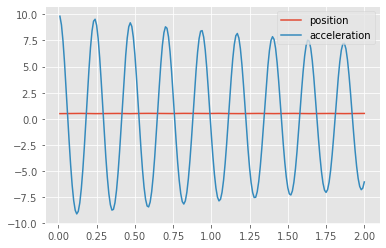

In [72]:
plt.style.use('ggplot')
%matplotlib inline

#definition of constants
g = 9.81 #gravity
m = .1   #mass 
cm = 1   #hall effect sensor mass coefficient
cv = 1   #hall effect sensor solenoid coefficient
cf = 1   #force of solenoid coefficient

#definition of simulation variables
size = 200   #number of points to plot
delta_t = .01 #time step between points
kp = 20       #proportional constant
kd = 1       #derivative constant
ki = 1       #integral constant
i_gain  = 0  #gain of integral part of controller
xi = .5      #starting position

#definition of input signal
target = .5
#definition of state arrays
force = np.zeros(size)        #force from solenoid
voltage = np.zeros(size)      #voltage across solenoid
pos = np.ones(size)*xi        #position of permanent magnet
vel = np.zeros(size)          #velocity of permanent magnet
accel = np.zeros(size)        #acceleration of permanent magnet
time = np.zeros(size)         #time
measured_pos = np.zeros(size) #measured position from sensor

for i in range(size):
    measured_pos = get_measured_position(measured_pos, voltage, pos, cv, cm)
    voltage, i_gain = get_voltage(voltage, target, pos, kp, kd, ki, i_gain, delta_t)
    force = get_force(force, voltage, pos, cf)
    accel = get_acceleration(accel, force, m)
    vel = get_velocity(vel, accel)
    pos = get_position(pos, vel)
    time = get_time(time, delta_t)
    
plt.plot(time, pos)
# plt.plot(time, measured_pos)
plt.plot(time, accel)
plt.legend(["position", "acceleration"])
# plt.ylim(-5, 5)
plt.show()

#### Live Plotting

<IPython.core.display.Javascript object>


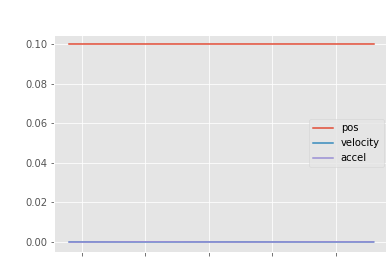

In [ ]:
plt.style.use('ggplot')
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

#definition of constants
g = 9.81 #gravity
m = .1   #mass 
cm = 1   #hall effect sensor mass coefficient
cv = 1   #hall effect sensor solenoid coefficient
cf = 1   #force of solenoid coefficient

#definition of simulation variables
size = 25   #number of points to plot
delta_t = .01 #time step between points
kp = 2       #proportional constant
kd = 1       #derivative constant
ki = 10       #integral constant
i_gain  = 0  #gain of integral part of controller
xi = .1      #starting position

#definition of input signal
target =  .1

#definition of state arrays
force = np.zeros(size)        #force from solenoid
voltage = np.zeros(size)      #voltage across solenoid
pos = np.ones(size)*xi        #position of permanent magnet
vel = np.zeros(size)          #velocity of permanent magnet
accel = np.zeros(size)        #acceleration of permanent magnet
time = np.zeros(size)         #time
measured_pos = np.zeros(size) #measured position from sensor

while True:
    measured_pos = get_measured_position(measured_pos, voltage, pos, cv, cm)
    voltage, i_gain = get_voltage(voltage, target, pos, kp, kd, ki, i_gain, delta_t)
    force = get_force(force, voltage, pos, cf)
    accel = get_acceleration(accel, force, m)
    vel = get_velocity(vel, accel)
    pos = get_position(pos, vel)
    time = get_time(time, delta_t)
    
    ax.clear()
    ax.plot(time, pos, label="pos")
    ax.plot(time, vel, label="velocity")
    ax.plot(time, accel, label="accel")
#     ax.plot(time, voltage)
    ax.legend()
    fig.canvas.draw()
    

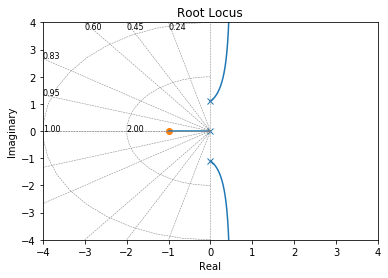

In [36]:
import numpy as np
from matplotlib import pyplot as plt 
import control

# 2a
G = control.TransferFunction((1, 1), (5, 0, 6, 0))

rlist, klist = control.rlocus(G, kvect=np.linspace(0, 20, num=100), plot=True, xlim=(-4,4), ylim=(-4, 4))